In [1]:
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from astropy import units as u
from astropy.coordinates import SkyCoord
from matplotlib.ticker import ScalarFormatter, NullFormatter
from svo_filters import svo 
import SedFitFunctions
import extinction
from inlist import *
from astropy.table import Table

fontsize=18
matplotlib.rcParams['text.usetex']=True
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
def load_filter_info(band=None):
    svoFilters = svo.filters().to_pandas()
    wavelength_eff = float(svoFilters.loc[band, "wave_eff"].split()[0])
    bandwidth = float(svoFilters.loc[band, "width_eff"].split()[0])
    f_lambda_0 = float(svoFilters.loc[band, "zp"].split("/")[0].split()[0])
    f_nu0 = F_lambda_to_F_nu(F_lambda=f_lambda_0, wavelength=wavelength_eff*1e4)
    return pd.DataFrame({"lambda":[wavelength_eff], "bandwidth":[bandwidth], "fnu0":[f_nu0]})

def svo_filters_list():
    svoFilters = svo.filters().to_pandas()
    print(np.sort(svoFilters.index.values))
    
def Flambda2Fnu(wave, flux_lambda):
    """Change flux in erg/cm^2/s/anstrogm to flux in Jy, where 1 Jy = 10^(-23) erg/cm^2/s/Hz. Note that
       wavelength in units of micron, instead of anstrogm"""
    return (wave*1e4)**2 / 2.998 * 10**5 * flux_lambda    


## $\color{red}{\text{Convertion between magnitude to flux density}}$

####  In the Vega magnitude system (also called the Johnson-Cousin magnitude system), magnitude and flux density are related via:
<h3><center>$m-m_{\rm{vega}} = -2.5 \rm{log}_{10} \frac{\textit{F}_{\nu, obs}[Jy]}{\textit{F}_{\nu,ref}[Jy]},\  \  \    (1.0)$</center></h3> 
or,
<h3><center>$m-m_{\rm{vega}} = -2.5 \rm{log}_{10} \frac{\textit{F}_{\lambda, obs}}{\textit{F}_{\lambda,ref}}$</center></h3>,


#### Here,  $m_{\rm{vega}}$  is the magnitudes of Vega in the Vega magnitude systems.  $\textit{F}_{\nu,\rm{ref}}$ is the flux density per unit frequency of Vega, while $\textit{F}_{\lambda,\rm{ref}}$ is the flux density per unit wavelength. The flux densities $\textit{F}_{\nu,\rm{ref}}$  and $\textit{F}_{\lambda,\rm{ref}}$ are convertable through:



<h3><center>$\textit{F}_{\nu,\rm{ref}} = \textit{F}_{\lambda,\rm{ref}} \frac{\lambda^{2}_{\rm{ref}}}{c}$ </center></h3>,

where $\lambda_{\rm{ref}}$ is historically called the pivot wavelength and defined as:
<h3><center>$\lambda_{\rm{ref}}=\sqrt{\frac{\int T(\lambda)\lambda\rm{d}\lambda}{\int\frac{T(\lambda)}{\lambda}\rm{d}\lambda}}$ </center></h3>.





####  In the AB magnitude system (assuming a flat spectrum, that is,  ${F_{\nu, \rm{ref}}}=3631\rm{Jy}$)
<h3><center>$m_{\rm{AB}} = -2.5 \rm{log}_{10} \textit{F}_{\nu, obs}[Jy] - 8.926 ,\  \  \    (1.1)$</center></h3> 

#### to correct extinction
<h3><center>$F_{\nu, 0} = F_{\nu, obs} 10^{(0.4A_{\lambda})} ,\  \  \    (1.2)$</center></h3> 
$F_{\nu, \rm{obs}}$ and  $F_{\nu, 0}$ are the observed flux densities before and after correcting the extinction. 

## $\color{red}{{\text{Definitions of the effective wavelength, bandwidth, and zero point of flux density}}}$
Effective wavelength:
<h3><center>$\lambda_{\rm mean} = \frac{\int_{}^{} \lambda T(\lambda)F_{\rm Vega}(\lambda) d\lambda}{\int_{}^{} T(\lambda)F_{\rm Vega}(\lambda)d\lambda}$</center></h3>

Bandwidth:
<h3><center>$W_{\rm eff} = \frac{\int_{}^{}  T(\lambda) d\lambda}{max[{T(\lambda)}]}$</center></h3>

Zero-point flux density:
<h3><center>$F_{\rm \lambda, ref} = \frac{\int_{}^{} \lambda T(\lambda) F_{\rm Vega}(\lambda)d\lambda}{\int_{}^{} \lambda T(\lambda) d\lambda}$</center></h3>

where $T(\lambda)$ is the filter transmission curve and $T(\lambda)$ is the Vega spectrum ( http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=browse&gname=SLOAN ). 

Similarly, to calculate the flux density of the model atmosphere for a star, 
<h3><center>$F_{\rm \lambda, star} = \frac{\int_{}^{}  T(\lambda) F_{\rm star}(\lambda)d\lambda}{\int_{}^{} T(\lambda) d\lambda}$</center></h3>

## $\color{red}{{\text{Optimize the scale factor $f_0$ and extinction $\beta$}}}$
The square law gives
<h3><center>$4\pi d^2 F_{\lambda, \rm 0} = 4\pi R^2 F_{\lambda, \rm mod},$</center></h3> namely
<h3><center>$F_{\lambda, \rm 0} =  f_0 F_{\lambda, \rm mod},$</center></h3> where $f_0=(R/d)^2$ is squared augular radius. Thus,
<h3><center>$F_{\lambda, \rm obs} = f_0 10^{-0.4\beta(\lambda)A_{V}} F_{\lambda, \rm mod},$</center></h3>or 
<h3><center>$\text{log}(F_{\lambda, \rm obs}) = \text{log}(F_{\lambda, \rm mod}) + \alpha-0.4\beta(\lambda)A_{V},$</center></h3>
where $\alpha=\text{log}f_0$, $\beta(\lambda)$ is an extinction law. The python package $\textit{extinction}$ has bundled up several widely used extinctions laws for quick access. Here the unknown is $\text{log}(F_{\lambda, \rm mod})$, the known is $\text{log}(F_{\lambda, \rm obs})$, and the parameters to be optimized are $\alpha$ and  $\beta$. Note that the parameters are $\color{red}{{\text{NOT}}}$ degenerated, because varing the extinction parameter $\beta$ changes the unknown $\text{log}(F_{\lambda, \rm mod})$. Thus, to optimize $\alpha$ and  $\beta$, the equation immediately above can be rearranged, i.e.,
<h3><center>$\text{log}(F_{\lambda, \rm obs}) - \text{log}(F_{\lambda, \rm mod}) = \alpha-0.4\beta(\lambda)A_{V},$</center></h3>
Now the independent variable is $\beta(\lambda)$, and the dependent variable is $\text{log}(F_{\lambda, \rm mod})$-$\text{log}(F_{\lambda, \rm obs})$. The problem is just a very simple linear model.

## $\color{red}{{\text{Acceptable broadband photometry for SED fittings}}}$
<h3><b>Johnson-Cousins:</b></h3> 'johnsoncousinsu','johnsoncousinsb','johnsoncousinsv','johnsoncousinsr','johnsoncousinsi' </br>
<h3><b>APASS</b></h3>:  'apassb', 'apassv', 'apassg', 'apassr', 'apassi',
</br>
<h3><b>SDSS:</b></h3>  'sdssu', 'sdssg', 'sdssr', 'sdssi', 'sdssz',
</br>
<h3><b>Gaia:</b></h3>  'gaiag', 'gaiabp', 'gaiarp', 
</br>
<h3><b>2MASS:</b></h3> '2massj', '2massh', '2massk',
</br>
<h3><b>WISE:</b></h3> 'wisew1', 'wisew2', 'wisew3', 'wisew4',
</br>
<h3><b>SPITZER/IRAC:</b></h3> 'iracl1', 'iracl2', 'iracl3', 'iracl4', 
</br>
<h3><b>IRAS:</b></h3>  'iras1', 'iras2', 'iras3', 'iras4'
</br>



<h4 style="color:black">
  
(1) The WISE W4 band has poor signal-to-noise ratios.<br>
(2) The APASS B,V, g, r, i bandpasses are the same as Johnson-Cousins B, V, and SDSS g, r, i, respectively.<br>
(3) SDSS u band photometry is not good for Kepler stars.<br>

<br>
<br>
<br>
</h4>


### python package: svo_filters
Instead of manually tabulating the effective wavelength and zero-point flux for each passband, one can use the python package svo_filters, which provids a method for accessing the required information.

svo_filters provides a convenient way for accessing basic information about a bandpass archived in SVO. Unfortunately, only a limited number of bandpasses are considered by svo_filters. Thus, it is generrally still necessary to manually organise bandpasses needed for perform SED fitting. 

to list all the bandpasses considered by svo_filters, run   
svo_filters_list() 

## Some Notes
#### Note that in what follows the wavelength of each filter collected from SVO is the pivot wavelength rather than the effective wavelength. The former is useful for converting the flux densities $\textit{F}_{\nu,\rm{ref}}$  and $\textit{F}_{\lambda,\rm{ref}}$ 

#### !!! Note that I define below the device of each filter, either photon-counting or energy amplitcation, according only to whether each filter transmission curve has been multiplied or not by wavelength from its orginal paper. Though current devices are nearly all phototon-counting devices, for the sake of calcuting flux densities using model spectra, we practically distinguish whether the multiplcation has been done or not rather than the physical origin of the detector.

#### I use value "unknown" as a placeholder for the filters that I have not yet checked. Note that the type of response functions, either photonic or energy, is taken from individual references and can be different from original specification due to subsequent revision. 

# Gaia Photometry (double checked)
To understand how to calculate Gaia synthetic magnitude, check Casagrande \& Vandenberg 2018. Gaia photometry is defined in the Vega magnitude system (page 13 of Evans et al. 2018). The transmission curves are from offical Gaia website, detector types are photon-counting, and zero points of flux densities are computed by myself with details given below.  

The original flux at the wavelength closest to 0.550 is 3.548323856961133e-09 at lambda=0.5499414
Linearly interpolated flux at 0.550 um is 3.5469249866636664e-09
The reference flux scale at 550 nm as for Riello+2021 is 3.62286e-9 erg s-1 cm-2 A-1
The scaling factor is 1.0214086888281673
f_lambda0 (erg s-1 cm-2 A-1): BP=4.110e-09 G=2.536e-09 RP=1.299e-09
f_nu0: BP=3578.928Jy G=3269.922Jy RP=2614.428Jy
For Vega: BP=-0.0001mag, G=-0.0003mag, RP=-0.0001map
f_lambda0 (erg s-1 cm-2 A-1) using a Vega spectrum from SVO: BP=4.078e-09 G=2.504e-09 RP=1.269e-09


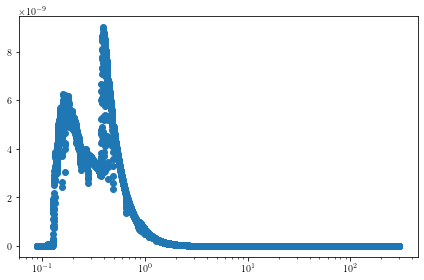

In [32]:
# GAIA DR2 revised curves.
# gaiabp = pd.DataFrame({"lambda":[0.50209], "bandwidth":[0.22794], "fnu0":[3393.3]})
# gaiag = pd.DataFrame({"lambda":[0.58363], "bandwidth":[0.43584], "fnu0":[2835.1]})
# gaiarp = pd.DataFrame({"lambda":[0.75888], "bandwidth":[0.29437], "fnu0":[2485.1]})
# GAIA EDR3

####################################################################################
# alpha_lyr_mod_002.fits from this website: 
# https://github.com/spacetelescope/NIRISS_magnitude_simulation
# The unit of flux in this fits file is erg s-1 cm-2 A-1, and the unit of waelength is angstrorms.
# Acoording to Riello+2021, Gaia photometry is calibrated on the Vega spectrum from the CALSPEC Calibration Database 
# rescaled to set the flux equal to f550 = 3.62286 10−11 W m−2 nm−1 at the wavelength λ = 550.0nm, which is assumed 
# as the flux of an unreddened A0V star with V = 0. 
# Note that: f550 = 3.62286e−11 W m−2 nm−1 = 3.62286e-11 * 1e7 erg/s 1e-4 cm-2 1e-1 A-1 = 3.62286e-9 erg s-1 cm-2 A-1
data = Table.read("../Data/MetaData/alpha_lyr_mod_002.fits").to_pandas()
data = data.rename(columns={"WAVELENGTH":"wavelength", "FLUX":"flux"})
data.loc[:, "wavelength"] /= 1e4

# check the Vega spectra.
subs = np.argmin(abs(data.wavelength-0.550))
print("The original flux at the wavelength closest to 0.550 is {:} at lambda={:}".format( data.loc[subs, "flux"], data.loc[subs, "wavelength"]))
print("Linearly interpolated flux at 0.550 um is {:}".format(np.interp(0.55, data.wavelength, data.flux)))
print("The reference flux scale at 550 nm as for Riello+2021 is 3.62286e-9 erg s-1 cm-2 A-1")

# rescale the Vega spectrum according to Riello+2021
scale_factor = 3.62286e-9/np.interp(0.55, data.wavelength, data.flux)
data.flux *= scale_factor
print("The scaling factor is {:}".format(scale_factor))

# calculate zeor points of flux densities for Gaia
a, b, c = SedFitFunctions.FluxDensity(data, bandpass=["gaiabp", "gaiag", "gaiarp"], path=filter_transmission_path)
print("f_lambda0 (erg s-1 cm-2 A-1): BP={:.3e} G={:.3e} RP={:.3e}".format(a, b, c))

wave_bp = 0.51097
fnu0_bp = Flambda2Fnu(wave_bp, a)
wave_g = 0.62176
fnu0_g = Flambda2Fnu(wave_g, b)
wave_rp = 0.77691
fnu0_rp = Flambda2Fnu(wave_rp, c)
print("f_nu0: BP={:.3f}Jy G={:.3f}Jy RP={:.3f}Jy".format(fnu0_bp, fnu0_g, fnu0_rp))


# calculate the zero points of the Gaia photometric system, namely the magnitudes of Vega.
m0_BP, m0_G, m0_RP = SedFitFunctions.GaiaMag(data, bandpass=["gaiabp", "gaiag", "gaiarp"], path=filter_transmission_path)
print("For Vega: BP={:.4f}mag, G={:.4f}mag, RP={:.4f}map".format(m0_BP, m0_G, m0_RP))

####################################################################################
# use the Vega spectrum downloaded from SVO to check if our calculated zeor points identical to theirs.
# the values are consistent with those from SVo, confirming that the sciprt is reliable.
svo = pd.read_csv("../Data/MetaData/vega_spectrum_svo.dat", sep="\s+")
svo.loc[:, "wavelength"] /= 1e4
a1, b1, c1 = SedFitFunctions.FluxDensity(svo, bandpass=["gaiabp", "gaiag", "gaiarp"], path=filter_transmission_path)
print("f_lambda0 (erg s-1 cm-2 A-1) using a Vega spectrum from SVO: BP={:.3e} G={:.3e} RP={:.3e}".format(a1, b1, c1))

fig, ax = plt.subplots(1,1)
ax.scatter(data.wavelength, data.flux)
ax.set_xscale("log")
plt.tight_layout()
plt.show()

gaiabp = pd.DataFrame({"lambda":[wave_bp], "bandwidth":[0.215750], "fnu0":[fnu0_bp], "m0":[0], "device":["photon"], "magsystem":["Vega"]})
gaiag  = pd.DataFrame({"lambda":[wave_g] , "bandwidth":[0.405297], "fnu0":[fnu0_g] , "m0":[0], "device":["photon"], "magsystem":["Vega"]})
gaiarp = pd.DataFrame({"lambda":[wave_rp], "bandwidth":[0.292444], "fnu0":[fnu0_rp], "m0":[0], "device":["photon"], "magsystem":["Vega"]})

## Hipparcos (double checked)
Using the revised transmission curve, response function type, and zero point revised by Mann & von Braun 2015. Alough the center wavelength listed in Table 2 is not clearly defined in the paper, we still use it since it does affect our final fit as the numbers are selfconsistently used. Note that the transmission curve from SVO is not identical to that given in the paper. Wavelength, bandwidth, and zero points were taken from the paper, and response functions are taken from the source file on arXiv. 

In [33]:
wave = 0.5586
flambda0_hp = 3.926e-9
fnu0_hp = Flambda2Fnu(wave, flambda0_hp)
hipparcos2hp = pd.DataFrame({"lambda": [wave], "bandwidth":[0.2569], "fnu0":[fnu0_hp], "m0":[0], "device":["energy"], "magsystem":["Vega"]})

## Tycho  (double checked)
Using the revised transmission curve, response function type, and zero point revised by Mann & von Braun 2015. Alough the center wavelength listed in Table 2 is not clearly defined in the paper, we still use it since it does affect our final fit as the numbers are selfconsistently used. Note that the transmission curve from SVO is not identical to that given in the paper. Wavelength, bandwidth, and zero points were taken from the paper, and response functions are taken from the source file on arXiv.  Tycho survey is complete to V=11 mag.

In [34]:
wave_bt, wave_vt = 0.4220, 0.5350
flambda0_bt, flambda0_vt = 6.798e-9, 4.029e-9
fnu0_bt = Flambda2Fnu(wave_bt, flambda0_bt)
fnu0_vt = Flambda2Fnu(wave_vt, flambda0_vt)
tycho2bt = pd.DataFrame({"lambda": [wave_bt], "bandwidth":[0.1455], "fnu0":[fnu0_bt], "m0":[0], "device":["energy"], "magsystem":["Vega"]})
tycho2vt = pd.DataFrame({"lambda": [wave_vt], "bandwidth":[0.1665], "fnu0":[fnu0_vt], "m0":[0], "device":["energy"], "magsystem":["Vega"]})

## PAN-STARRS Photometry (double checked)
Filter profiles were taken from:https://ipp.ifa.hawaii.edu/ps1.filters/. The filter type and mag system type are from Table 1 of Casagrande & Vandenberg 2018. Pivot wavelengths were calculated by myself.

In [35]:
bandpass = ["panstarrsps1g", "panstarrsps1r", "panstarrsps1i", "panstarrsps1z", "panstarrsps1y"]
waveg, waver, wavei, wavez, wavey = SedFitFunctions.pivotwave(bandpass=bandpass, path=filter_transmission_path)
panstarrsps1g =  pd.DataFrame({"lambda":[waveg], "bandwidth":[0.105308], "fnu0":[3631.00], "m0":[0], "device":["energy"], "magsystem":["AB"]})
panstarrsps1r =  pd.DataFrame({"lambda":[waver], "bandwidth":[0.125241], "fnu0":[3631.00], "m0":[0], "device":["energy"], "magsystem":["AB"]})
panstarrsps1i =  pd.DataFrame({"lambda":[wavei], "bandwidth":[0.120663], "fnu0":[3631.00], "m0":[0], "device":["energy"], "magsystem":["AB"]})
panstarrsps1z =  pd.DataFrame({"lambda":[wavez], "bandwidth":[0.099771], "fnu0":[3631.00], "m0":[0], "device":["energy"], "magsystem":["AB"]})
panstarrsps1y =  pd.DataFrame({"lambda":[wavey], "bandwidth":[0.063899], "fnu0":[3631.00], "m0":[0], "device":["energy"], "magsystem":["AB"]})

# APASS Photometry (double checked)
This survey is conducted in eight filters: Johnson B and V, plus Sloan u', g′, r′, i′, z_s and Z from the APASS catalog, only Johnson B and V plus Sloan  g′, r′, and i′ are listed.
The B and V magnitdes are in the Johnson magnitude system, while g′, r′, and i′ magnitudes are in the AB magnitude system. This can be seen from VizieR: 
https://vizier.u-strasbg.fr/viz-bin/VizieR?-source=II/336. The survey covers the magnitude range 10<V<17. The photometric system parameters are taken from Mann & von Braun for Johnson B and V bands and from SDSS website and Casagrande & Vandenberg 2018 for g′, r′, and i′ bands

In [36]:
waveb, wavev = 0.4412, 0.5529
flambda0_b, flambda0_v = 6.459e-9, 3.735e-9
fnu0_b = Flambda2Fnu(waveb, flambda0_b)
fnu0_v = Flambda2Fnu(wavev, flambda0_v)
apassB = pd.DataFrame({"lambda":[waveb], "bandwidth":[0.1816], "fnu0":[fnu0_b], "m0": [0], "device":["energy"], "magsystem":["Vega"]})
apassV = pd.DataFrame({"lambda":[wavev], "bandwidth":[0.1129], "fnu0":[fnu0_v], "m0": [0], "device":["energy"], "magsystem":["Vega"]})

waveg, waver, wavei = SedFitFunctions.pivotwave(bandpass=["sdssg", "sdssr", "sdssi"], path=filter_transmission_path)
apassg = pd.DataFrame({"lambda": [waveg], "bandwidth":[0.11584], "fnu0": [3631], "m0": [-0.010], "device":["photon"], "magsystem":["AB"]})
apassr = pd.DataFrame({"lambda": [waver], "bandwidth":[0.11112], "fnu0": [3631], "m0": [0.003],  "device":["photon"], "magsystem":["AB"]})
apassi = pd.DataFrame({"lambda": [wavei], "bandwidth":[0.10446], "fnu0": [3631], "m0": [-0.006], "device":["photon"], "magsystem":["AB"]})

# SDSS Photometry (double checked)

The calibration process ultimately involves combining data from three telescopes: the USNO 40-in on which the primary standards were first measured, the SDSS Photometric Telescope (or PT), and the SDSS 2.5m telescope. Magnitudes in the the USNO 40-in system are primed (u'g'r'i'z'), while magnitudes in the SDSS 2.5m system are unprimed (ugriz) ( http://classic.sdss.org/dr7/algorithms/fluxcal.html ).


Pinsonneault et al. (2012) found systematic differences in the KIC (ugriz) photometry with respect to SDSS (ugriz) photometry, for 10% of the stars in the Kepler field covered in the data release (DR8) of the SDSS imaging survey (Aihara et al.2011).
<pre>
g<sub>SDSS</sub>=g<sub>KIC</sub>+0.0921(g−r)_<sub>KIC</sub>−0.0985
r<sub>SDSS</sub>=r<sub>KIC</sub>+0.0548(r−i)_<sub>KIC</sub>−0.0383
i<sub>SDSS</sub>=i<sub>KIC</sub>+0.0696(r−i)_<sub>KIC</sub>−0.0583
z<sub>SDSS</sub>=z<sub>KIC</sub>+0.1587(i−z)_<sub>KIC</sub>−0.0597
</pre>

Note that the KIC (ugriz) photometry is based on the AB magnitude system ( http://archive.stsci.edu/kepler/kepler_fov/explanations.html ), Euqation (1.1) should be used to derive the flux density without the zero points of the flux density for each band. Below I list the zero points of the flux density for completeness.

filter profiles were taken from SDSS website: http://classic.sdss.org/dr7/instruments/imager/index.html. I calculated pivot wavelength from the filter profiles. Only bandwidths are taken from SVO.

In [37]:
waveu, waveg, waver, wavei, wavez = SedFitFunctions.pivotwave(bandpass=["sdssu", "sdssg", "sdssr", "sdssi", "sdssz"], path=filter_transmission_path)
print("pivot wavelength (micron): u={:.5f}, g={:.5f}, r={:.5f}, i={:.5f}, z={:.5f}".format(waveu, waveg, waver, wavei, wavez))
sdssu = pd.DataFrame({"lambda": [waveu], "bandwidth":[0.05584], "fnu0": [3631], "m0": [0.037], "device":["photon"], "magsystem":["AB"]})
sdssg = pd.DataFrame({"lambda": [waveg], "bandwidth":[0.11584], "fnu0": [3631], "m0": [-0.010], "device":["photon"], "magsystem":["AB"]})
sdssr = pd.DataFrame({"lambda": [waver], "bandwidth":[0.11112], "fnu0": [3631], "m0": [0.003], "device":["photon"], "magsystem":["AB"]})
sdssi = pd.DataFrame({"lambda": [wavei], "bandwidth":[0.10446], "fnu0": [3631], "m0": [-0.006], "device":["photon"], "magsystem":["AB"]})
sdssz = pd.DataFrame({"lambda": [wavez], "bandwidth":[0.11246], "fnu0": [3631], "m0": [-0.016], "device":["photon"], "magsystem":["AB"]})

pivot wavelength (micron): u=0.35565, g=0.47025, r=0.61756, i=0.74900, z=0.89467


# SkyMapper (double checked)
The fileter transmission curves for the six filters were taken from Bessell+2011 (arXiv source file) and fileter type, zero points, and mag system are taken from Casagrande & Vandenberg 2018. Note that SVO gives a slightly different filter profile of u bandpass than that of Russell+2011. I use the one from the paper, which leads to a slightly different pivot wavelength.

In [38]:
waveu, wavev, waveg, waver, wavei, wavez = SedFitFunctions.pivotwave(
    bandpass=["skymapperu", "skymapperv", "skymapperg", "skymapperr", "skymapperi", "skymapperz"], 
    path=filter_transmission_path)
print("pivot wavelength (micron): u={:.6f}, v={:.6f}, g={:.6f}, r={:.6f}, i={:.6f}, z={:.6f}".format(waveu, wavev, waveg, waver, wavei, wavez))

pivot wavelength (micron): u=0.351664, v=0.383593, g=0.507519, r=0.613844, i=0.776798, z=0.914599


In [39]:
waveu, wavev, waveg, waver, wavei, wavez = SedFitFunctions.pivotwave(
    bandpass=["skymapperu", "skymapperv", "skymapperg", "skymapperr", "skymapperi", "skymapperz"], 
    path=filter_transmission_path)
skymapperu = pd.DataFrame({"lambda": [waveu], "bandwidth":[0.041886], "fnu0": [3631], "m0": [0.], "device":["photon"], "magsystem":["AB"]})
skymapperv = pd.DataFrame({"lambda": [wavev], "bandwidth":[0.031906], "fnu0": [3631], "m0": [0.], "device":["photon"], "magsystem":["AB"]})
skymapperg = pd.DataFrame({"lambda": [waveg], "bandwidth":[0.145060], "fnu0": [3631], "m0": [0.], "device":["photon"], "magsystem":["AB"]})
skymapperr = pd.DataFrame({"lambda": [waver], "bandwidth":[0.141405], "fnu0": [3631], "m0": [0.], "device":["photon"], "magsystem":["AB"]})
skymapperi = pd.DataFrame({"lambda": [wavei], "bandwidth":[0.124620], "fnu0": [3631], "m0": [0.], "device":["photon"], "magsystem":["AB"]})
skymapperz = pd.DataFrame({"lambda": [wavez], "bandwidth":[0.115857], "fnu0": [3631], "m0": [0.], "device":["photon"], "magsystem":["AB"]})
print("pivot wavelength (micron): u={:.5f}, v={:.5f}, g={:.5f}, r={:.5f}, i={:.5f}, z={:.5f}".format(waveu, wavev, waveg, waver, wavei, wavez))

pivot wavelength (micron): u=0.35166, v=0.38359, g=0.50752, r=0.61384, i=0.77680, z=0.91460


# 2MASS Photometry (double checked)
2MASS magnitudes are normalised to a Vega system, but with Vega having a magnitude of 0.00 rather than 0.03 as in the Johnson system. Objects brighter than around 4th magnitude in any of the 2MASS bands are saturated, so 2MASS photometry is only accurate for sources fainter than this. Atmospheric transmission uncertainty limits the precision of 2MASS magnitudes to about σ=0.04 mag. Reference https://www.roe.ac.uk/ifa/postgrad/pedagogy/2008_phillips.pdf 2MASS Isophotal Bandpasses and Fluxes-for-0-magnitude. Reference: https://old.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4a.html. The high-quality calibration of 2MASS photometry has been widely accepted, e.g., see Mann & von Braun 2015. The response function data was taken from from the reference above, rather than from SVO, where the latter is not identical to the offical table. 

In [40]:
twomassJ = pd.DataFrame({"lambda":[1.235], "bandwidth":[0.16241], "fnu0":[1594], "m0":[-0.018], "device":["energy"], "magsystem":["Vega"]})
twomassH = pd.DataFrame({"lambda":[1.662], "bandwidth":[0.25094], "fnu0":[1024], "m0":[0.035], "device":["energy"], "magsystem":["Vega"]})
twomassK = pd.DataFrame({"lambda":[2.159], "bandwidth":[0.26189], "fnu0":[666.7],"m0":[-0.014], "device":["energy"], "magsystem":["Vega"]})

# WISE Photometry (double checked)
WISE magnitudes are normalised to a Vega system, but with Vega having a magnitude of 0.00 rather than 0.03 as in the Johnson system. The zero magnitude flux densities and the wavelengths were adopted from Table 9, both at the webpage:https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html. Note that the differrence between the filter profiles given in Fig5a and Fig 5b is that the former have not been multiplied by wavelength (i.e., photon-counting), where the latter have (i.e., energy-integration). 

In [41]:
wisew1 = pd.DataFrame({"lambda":[3.3526],  "bandwidth":[0.66264], "fnu0":[309.540], "m0":[0], "device":["energy"], "magsystem":["Vega"]})
wisew2 = pd.DataFrame({"lambda":[4.6028],  "bandwidth":[1.04227], "fnu0":[171.787], "m0":[0], "device":["energy"], "magsystem":["Vega"]})
wisew3 = pd.DataFrame({"lambda":[11.5608], "bandwidth":[5.50557], "fnu0":[31.674],  "m0":[0], "device":["energy"], "magsystem":["Vega"]})
wisew4 = pd.DataFrame({"lambda":[22.0883], "bandwidth":[4.10168], "fnu0":[8.363],   "m0":[0], "device":["energy"], "magsystem":["Vega"]})

# Combine all above photometry

In [42]:
# calculate pivot wavlength.
# filters = pd.read_csv("../Data/MetaData/filters.dat")
# wave = SedFit_Functions.pivotwave(filters.band.values.copy(), path=filter_transmission_path)

# the lambda and bandwidth are in the units of micrometer, and the fnu0 is in the units of Janksky.                  
total = pd.concat([panstarrsps1g, panstarrsps1r, panstarrsps1i, panstarrsps1z, panstarrsps1y,\
                   skymapperu, skymapperv, skymapperg, skymapperr, skymapperi, skymapperz, \
                   hipparcos2hp,\
                   tycho2bt, tycho2vt,\
                   apassB, apassV, apassg, apassr, apassi,\
                   sdssu, sdssg, sdssr, sdssi, sdssz,\
                   gaiag, gaiabp, gaiarp, \
                   twomassJ, twomassH, twomassK, \
                   wisew1, wisew2, wisew3, wisew4])

total["band"] = ["panstarrsps1g", "panstarrsps1r", "panstarrsps1i", "panstarrsps1z", "panstarrsps1y",\
                 "skymapperu", "skymapperv", "skymapperg", "skymapperr", "skymapperi", "skymapperz", \
                 "hipparcos2hp",\
                 "tycho2bt", "tycho2vt", \
                 "apassb", "apassv", "apassg", "apassr", "apassi", \
                 "sdssu", "sdssg", "sdssr", "sdssi", "sdssz", \
                 "gaiag", "gaiabp", "gaiarp", \
                 "twomassj", "twomassh", "twomassk", \
                 "wisew1", "wisew2", "wisew3", "wisew4"]




# use the package extinction to access several widely used extinction laws.    
total.loc[:, "Alambda_Over_Av"] = extinction.ccm89(total.loc[:,"lambda"].values*1e4, 1.0, 3.1)
total = total[["band", "lambda", "bandwidth", "fnu0", "m0", "Alambda_Over_Av", "device", "magsystem"]].reset_index(drop=True)

/home/yujie/Documents/SoftLinks/Data/Softwares/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


# Output

In [43]:
print(total)
total.to_csv("../Data/MetaData/filters.dat", index=False, float_format="%.6f")

             band     lambda  bandwidth         fnu0     m0  Alambda_Over_Av  \
0   panstarrsps1g   0.481414   0.105308  3631.000000  0.000         1.179214   
1   panstarrsps1r   0.617431   0.125241  3631.000000  0.000         0.878386   
2   panstarrsps1i   0.751576   0.120663  3631.000000  0.000         0.670020   
3   panstarrsps1z   0.866359   0.099771  3631.000000  0.000         0.512016   
4   panstarrsps1y   0.961685   0.063899  3631.000000  0.000         0.430228   
5      skymapperu   0.351664   0.041886  3631.000000  0.000         1.587534   
6      skymapperv   0.383593   0.031906  3631.000000  0.000         1.511979   
7      skymapperg   0.507519   0.145060  3631.000000  0.000         1.100987   
8      skymapperr   0.613844   0.141405  3631.000000  0.000         0.884125   
9      skymapperi   0.776798   0.124620  3631.000000  0.000         0.631599   
10     skymapperz   0.914599   0.115857  3631.000000  0.000         0.466444   
11   hipparcos2hp   0.558600   0.256900 

# The Spectral Windows

In [30]:

# Johnson-Cousins UBVRI
johnsoncousinsu =  pd.read_csv("../Data/MetaData/SpectralWindows/johnsoncousinsu.dat")
johnsoncousinsb =  pd.read_csv("../Data/MetaData/SpectralWindows/johnsoncousinsb.dat")
johnsoncousinsv =  pd.read_csv("../Data/MetaData/SpectralWindows/johnsoncousinsv.dat")
johnsoncousinsr =  pd.read_csv("../Data/MetaData/SpectralWindows/johnsoncousinsr.dat")
johnsoncousinsi =  pd.read_csv("../Data/MetaData/SpectralWindows/johnsoncousinsi.dat")


# Pan-STARRs
panstarrsps1g =  pd.read_csv("../Data/MetaData/SpectralWindows/panstarrsps1g.dat")
panstarrsps1r =  pd.read_csv("../Data/MetaData/SpectralWindows/panstarrsps1r.dat")
# panstarrsps1w =  pd.read_csv("../Data/MetaData/SpectralWindows/panstarrsps1w.dat")
# panstarrsps1open =  pd.read_csv("../Data/MetaData/SpectralWindows/panstarrsps1open.dat")
panstarrsps1i =  pd.read_csv("../Data/MetaData/SpectralWindows/panstarrsps1i.dat")
panstarrsps1z =  pd.read_csv("../Data/MetaData/SpectralWindows/panstarrsps1z.dat")
panstarrsps1y =  pd.read_csv("../Data/MetaData/SpectralWindows/panstarrsps1y.dat")

# Tycho2
tycho2bt = pd.read_csv("../Data/MetaData/SpectralWindows/tycho2bt.dat")
tycho2vt = pd.read_csv("../Data/MetaData/SpectralWindows/tycho2vt.dat")

# Gaia
gaiag = pd.read_csv("../Data/MetaData/SpectralWindows/gaiag.dat")
gaiabp = pd.read_csv("../Data/MetaData/SpectralWindows/gaiabp.dat")
gaiarp = pd.read_csv("../Data/MetaData/SpectralWindows/gaiarp.dat")

# SDSS
sdssu = pd.read_csv("../Data/MetaData/SpectralWindows/sdssu.dat")
sdssg = pd.read_csv("../Data/MetaData/SpectralWindows/sdssg.dat")
sdssr = pd.read_csv("../Data/MetaData/SpectralWindows/sdssr.dat")
sdssi = pd.read_csv("../Data/MetaData/SpectralWindows/sdssi.dat")
sdssz = pd.read_csv("../Data/MetaData/SpectralWindows/sdssz.dat")

# TWOMASS
twomassj = pd.read_csv("../Data/MetaData/SpectralWindows/twomassj.dat")
twomassh = pd.read_csv("../Data/MetaData/SpectralWindows/twomassh.dat")
twomassk = pd.read_csv("../Data/MetaData/SpectralWindows/twomassk.dat")

# WISE
wisew1 = pd.read_csv("../Data/MetaData/SpectralWindows/wisew1.dat")
wisew2 = pd.read_csv("../Data/MetaData/SpectralWindows/wisew2.dat")
wisew3 = pd.read_csv("../Data/MetaData/SpectralWindows/wisew3.dat")
wisew4 = pd.read_csv("../Data/MetaData/SpectralWindows/wisew4.dat")

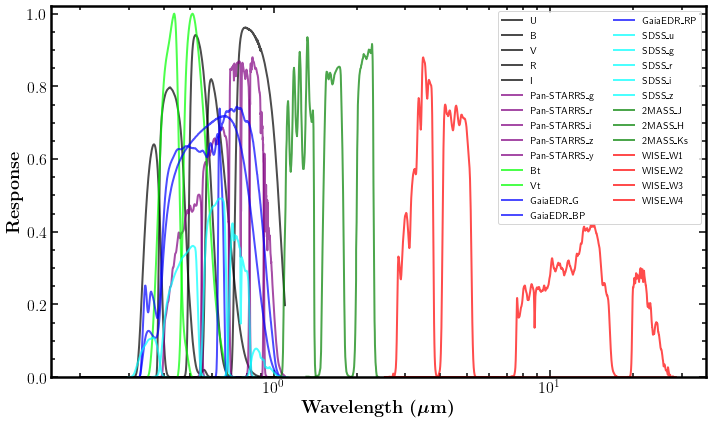

In [43]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(johnsoncousinsu.wavelength, johnsoncousinsu.response,   lw=2.0,  alpha=0.7, c='k', label="U")
ax.plot(johnsoncousinsb.wavelength, johnsoncousinsb.response,   lw=2.0,  alpha=0.7, c='k', label="B")
ax.plot(johnsoncousinsv.wavelength, johnsoncousinsv.response,   lw=2.0,  alpha=0.7, c='k', label="V")
ax.plot(johnsoncousinsr.wavelength, johnsoncousinsr.response,   lw=2.0,  alpha=0.7, c='k', label="R")
ax.plot(johnsoncousinsi.wavelength, johnsoncousinsi.response,   lw=2.0,  alpha=0.7, c='k', label="I")

ax.plot(panstarrsps1g.wavelength, panstarrsps1g.response,   lw=2.0,  alpha=0.7, c='purple', label="Pan-STARRS\_g")
ax.plot(panstarrsps1r.wavelength, panstarrsps1r.response,   lw=2.0,  alpha=0.7, c='purple', label="Pan-STARRS\_r")
ax.plot(panstarrsps1i.wavelength, panstarrsps1i.response,   lw=2.0,  alpha=0.7, c='purple', label="Pan-STARRS\_i")
ax.plot(panstarrsps1z.wavelength, panstarrsps1z.response,   lw=2.0,  alpha=0.7, c='purple', label="Pan-STARRS\_z")
ax.plot(panstarrsps1y.wavelength, panstarrsps1y.response,   lw=2.0,  alpha=0.7, c='purple', label="Pan-STARRS\_y")


ax.plot(tycho2bt.wavelength, tycho2bt.response, lw=2.0,  alpha=0.7, c='lime', label="Bt")
ax.plot(tycho2vt.wavelength, tycho2vt.response, lw=2.0,  alpha=0.7, c='lime', label="Vt")

ax.plot(gaiag.wavelength, gaiag.response,   lw=2.0,  alpha=0.7, c='b', label="GaiaEDR\_G")
ax.plot(gaiabp.wavelength, gaiabp.response, lw=2.0,  alpha=0.7, c='b', label="GaiaEDR\_BP")
ax.plot(gaiarp.wavelength, gaiarp.response, lw=2.0,  alpha=0.7, c='b', label="GaiaEDR\_RP")


ax.plot(sdssu.wavelength, sdssu.response, lw=2.0,  alpha=0.7, c='cyan', label="SDSS\_u")
ax.plot(sdssg.wavelength, sdssg.response, lw=2.0,  alpha=0.7, c='cyan', label="SDSS\_g")
ax.plot(sdssr.wavelength, sdssr.response, lw=2.0,  alpha=0.7, c='cyan', label="SDSS\_r")
ax.plot(sdssi.wavelength, sdssi.response, lw=2.0,  alpha=0.7, c='cyan', label="SDSS\_i")
ax.plot(sdssz.wavelength, sdssz.response, lw=2.0,  alpha=0.7, c='cyan', label="SDSS\_z")


ax.plot(twomassj.wavelength, twomassj.response, lw=2.0,  alpha=0.7, c='g', label="2MASS\_J")
ax.plot(twomassh.wavelength, twomassh.response, lw=2.0,  alpha=0.7, c='g', label="2MASS\_H")
ax.plot(twomassk.wavelength, twomassk.response, lw=2.0,  alpha=0.7, c='g', label="2MASS\_Ks")


ax.plot(wisew1.wavelength, wisew1.response, lw=2.0,  alpha=0.7, c='r', label="WISE\_W1")
ax.plot(wisew2.wavelength, wisew2.response, lw=2.0,  alpha=0.7, c='r', label="WISE\_W2")
ax.plot(wisew3.wavelength, wisew3.response, lw=2.0,  alpha=0.7, c='r', label="WISE\_W3")
ax.plot(wisew4.wavelength, wisew4.response, lw=2.0,  alpha=0.7, c='r', label="WISE\_W4")


ax.set_xlabel(r"$\boldsymbol{\rm Wavelength\ (\mu m)}$", fontsize=fontsize)
ax.set_ylabel(r"$\boldsymbol{\rm Response}$", fontsize=fontsize)

ax.set_ylim(0,1.02)
# ax.set_xlim(0, 40)
ax.set_xscale("log")
ax.legend(ncol=2)
plt.tight_layout()
plt.savefig("../Figures/FilterTransmission.png")